In [34]:
now = datetime.now()

In [35]:
now.strftime("%Y%m%d%H%M")

'202012291445'

In [38]:
runs = "runs"
timestamp = now.strftime("%Y%m%d%H%M") 
path = os.path.join(runs,timestamp)

In [39]:
path

'runs\\202012291445'

## <font color=#6B49F5> A Simple Implementation of FedAvg with PyTorch on IID Data </font> 
Please see https://towardsdatascience.com/federated-learning-a-simple-implementation-of-fedavg-federated-averaging-with-pytorch-90187c9c9577 for more details.

In [ ]:

!pip install torch

In [1]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import random
import math
#from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot

from keras.datasets import mnist

from pathlib import Path
import requests
import pickle
import gzip

import torch
import math
import torch.nn.functional as F
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import random
import math

from datetime import datetime


In [ ]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()



11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
train_y.shape

(60000,)

In [2]:
class Net2nn(nn.Module):
    def __init__(self):
        super(Net2nn, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
setup = Setup("")

In [ ]:
setup.list_of_clients[3].x_train.shape

(12000, 784)

In [ ]:
setup.server.main_model.fc1.weight.data

tensor([[-0.0147, -0.0084,  0.0076,  ...,  0.0289,  0.0034, -0.0081],
        [-0.0240,  0.0113, -0.0147,  ...,  0.0310, -0.0228, -0.0350],
        [-0.0256,  0.0068,  0.0195,  ...,  0.0301,  0.0057,  0.0291],
        ...,
        [-0.0081, -0.0106,  0.0149,  ...,  0.0098,  0.0163, -0.0146],
        [-0.0202,  0.0233, -0.0104,  ...,  0.0229,  0.0046, -0.0109],
        [-0.0051,  0.0031, -0.0149,  ..., -0.0255,  0.0321, -0.0307]])

In [ ]:
my_x = [np.array([[1.0,2],[3,4]]),np.array([[5.,6],[7,8]])] # a list of numpy arrays
my_y = [np.array([4.]), np.array([2.])] # another list of numpy arrays (targets)

tensor_x = torch.Tensor(my_x) # transform to torch tensor
tensor_y = torch.Tensor(my_y)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset) # create your dataloader


In [ ]:
setup = Setup("")

In [ ]:
setup.list_of_clients[0].x_train.shape

torch.Size([12000, 784])

In [ ]:
setup.run(1)

0th run of the federated learning
Client 3 | epoch:   1 | train accuracy: 0.74150 | test accuracy: 0.90300
Client 3 | epoch:   2 | train accuracy: 0.90358 | test accuracy: 0.92400
Client 3 | epoch:   3 | train accuracy: 0.93133 | test accuracy: 0.94150
Client 3 | epoch:   4 | train accuracy: 0.94675 | test accuracy: 0.93900
Client 3 | epoch:   5 | train accuracy: 0.95808 | test accuracy: 0.95250
Client 3 | epoch:   6 | train accuracy: 0.96842 | test accuracy: 0.95050
Client 3 | epoch:   7 | train accuracy: 0.97467 | test accuracy: 0.95850
Client 3 | epoch:   8 | train accuracy: 0.98050 | test accuracy: 0.95650
Client 3 | epoch:   9 | train accuracy: 0.98483 | test accuracy: 0.95800
Client 3 | epoch:  10 | train accuracy: 0.98825 | test accuracy: 0.96200
Client 1 | epoch:   1 | train accuracy: 0.74450 | test accuracy: 0.88700
Client 1 | epoch:   2 | train accuracy: 0.90850 | test accuracy: 0.91500
Client 1 | epoch:   3 | train accuracy: 0.93083 | test accuracy: 0.92350
Client 1 | epoch:

In [115]:
class Setup:
    '''Read the dataset, instantiate the clients and the server
       It receive in input the path to the data, and the number of clients
    '''

    def __init__(self, conf_file):
        self.conf_file = conf_file
        
        self.settings = self.load(self.conf_file)
        
        self.data_path = self.settings['setup']['data_path']
        self.n_clients = self.settings['setup']['n_clients']
        self.learning_rate = self.settings['setup']['learning_rate']
        self.num_of_epochs = self.settings['setup']['num_of_epochs']
        self.batch_size = self.settings['setup']['batch_size']
        self.momentum = self.settings['setup']['momentum']
        self.random_clients = self.settings['setup']['random_clients']
        self.saving_dir = self.settings['setup']['save_dir']
        self.saved = False
                
        if "saved" not in self.settings.keys():
            self.start_time = datetime.now()
        else:
            self.saved = True
            self.start_time = datetime.strptime(self.settings['saved']['timestamp'],'%Y%m%d%H%M')
    
        timestamp = self.start_time.strftime("%Y%m%d%H%M") 
        self.path = os.path.join(self.saving_dir,timestamp)

        print("CREATING CLIENTS: ")
        print("\t",self.path)
        print("\t",self.saved)
        
        self.list_of_clients = []
        self.X_train, self.y_train, self.X_test, self.y_test = self.__load_dataset()

        self.create_clients()

        self.server = Server(self.list_of_clients, self.random_clients,
                             self.learning_rate, self.num_of_epochs, 
                             self.batch_size, self.momentum,
                             self.saved,self.path)

    def load(self,conf_file):
        with open(conf_file) as f:
            settings = yaml.load(f,Loader=yaml.FullLoader)
            return settings
        
        
    def run(self, federated_runs=10):
        for i in range(federated_runs):
            print("{}th run of the federated learning".format(i))
            self.server.training_clients()
            self.server.update_averaged_weights()
            self.server.send_weights()

    def __load_dataset(self):
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
        X_train = X_train.reshape(X_train.shape[0], 784)
        X_test = X_test.reshape(X_test.shape[0], 784)
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')
        # Original data is uint8 (0-255). Scale it to range [0,1].
        X_train /= 255
        X_test /= 255

        return X_train, y_train, X_test, y_test

    def __create_iid_datasets(self):
        # 1. randomly shuffle both train and test sets
        X_train, y_train = shuffle(self.X_train, self.y_train, random_state=42)
        X_test, y_test = shuffle(self.X_test, self.y_test, random_state=42)
        # 2. split evenly both train and test sets by the number of clients
        X_trains = np.array_split(X_train, self.n_clients)
        y_trains = np.array_split(y_train, self.n_clients)
        X_tests = np.array_split(X_test, self.n_clients)
        y_tests = np.array_split(y_test, self.n_clients)

        return X_trains, y_trains, X_tests, y_tests

    def create_clients(self, iid=True):

        if iid:
            X_trains, y_trains, X_tests, y_tests = self.__create_iid_datasets()
        else:
            X_trains, y_trains, X_tests, y_tests = self.__create_non_iid_datasets()

        for i in range(self.n_clients):
            c = Client(str(i), X_trains[i], y_trains[i], X_tests[i],y_tests[i], self.learning_rate,
                 self.num_of_epochs, self.batch_size, self.momentum,self.saved, self.path)
            self.list_of_clients.append(c)

    def add_clients(self, client):
        self.list_of_clients.append(client)

    def save_models(self):
        self.server.save_model(self.path)
        for c in self.list_of_clients:
            c.save_model(self.path)
    
    def save(self):
        timestamp = self.start_time.strftime("%Y%m%d%H%M") 
        self.path = os.path.join(self.saving_dir,timestamp)
        if not os.path.exists(self.path):
            os.mkdir(self.path)
        self.save_models()
        self.settings['saved'] = {"timestamp":timestamp}
        with open(os.path.join(self.path,'setup.yaml'),'w') as fout:
            yaml.dump(self.settings,fout)

In [133]:
class Server:
    '''
    The Server class owns the central model.
    - It initializes the main model and it updates the weights to the clients
    - It handles the training among the clients
    - It receives the weights from clients and it averages them for its main
      model updating it
    '''

    def __init__(self, list_of_clients, random_clients, 
                 learning_rate=0.01, num_of_epochs=10,
                 batch_size=32, momentum=0.9,
                 saved=False,path=None
                 ):
        
        self.list_of_clients = list_of_clients
        self.random_clients = random_clients
        self.learning_rate = learning_rate
        self.num_of_epochs = num_of_epochs
        self.batch_size = batch_size
        self.momentum = momentum

        self.selected_clients = []
        self.main_model = Net2nn()
        if saved:
            self.main_model.load_state_dict(torch.load(os.path.join(path,"main_model")))
        
        self.main_optimizer = torch.optim.SGD(
            self.main_model.parameters(), lr=self.learning_rate, momentum=self.momentum)
        self.main_criterion = nn.CrossEntropyLoss()
        self.send_weights()

    def send_weights(self):
        for c in self.list_of_clients:
            c.update_model_weights(self.main_model)

    def training_clients(self):
        self.selected_clients = random.sample(self.list_of_clients, math.floor(
            len(self.list_of_clients)*self.random_clients))
        for c in self.selected_clients:
            c.call_training(self.num_of_epochs)

    def get_averaged_weights(self):

        fc1_mean_weight = torch.zeros(
            size=self.list_of_clients[0].model.fc1.weight.shape)
        fc1_mean_bias = torch.zeros(
            size=self.list_of_clients[0].model.fc1.bias.shape)

        fc2_mean_weight = torch.zeros(
            size=self.list_of_clients[0].model.fc2.weight.shape)
        fc2_mean_bias = torch.zeros(
            size=self.list_of_clients[0].model.fc2.bias.shape)

        fc3_mean_weight = torch.zeros(
            size=self.list_of_clients[0].model.fc3.weight.shape)
        fc3_mean_bias = torch.zeros(
            size=self.list_of_clients[0].model.fc3.bias.shape)

        with torch.no_grad():
            for c in self.selected_clients:
                print("GETTING WEIGHTS FOR ", c.id)
                fc1_mean_weight += c.model.fc1.weight.data.clone()
                fc1_mean_bias += c.model.fc1.bias.data.clone()

                fc2_mean_weight += c.model.fc2.weight.data.clone()
                fc2_mean_bias += c.model.fc2.bias.data.clone()

                fc3_mean_weight += c.model.fc3.weight.data.clone()
                fc3_mean_bias += c.model.fc3.bias.data.clone()

            fc1_mean_weight = fc1_mean_weight/len(self.selected_clients)
            fc1_mean_bias = fc1_mean_bias/len(self.selected_clients)

            fc2_mean_weight = fc2_mean_weight/len(self.selected_clients)
            fc2_mean_bias = fc2_mean_bias/len(self.selected_clients)

            fc3_mean_weight = fc3_mean_weight/len(self.selected_clients)
            fc3_mean_bias = fc3_mean_bias/len(self.selected_clients)

        return fc1_mean_weight, fc1_mean_bias, fc2_mean_weight, fc2_mean_bias, fc3_mean_weight, fc3_mean_bias

    def update_averaged_weights(self):
        fc1_mean_weight, fc1_mean_bias, fc2_mean_weight, fc2_mean_bias, fc3_mean_weight, fc3_mean_bias = self.get_averaged_weights()
        with torch.no_grad():
            self.main_model.fc1.weight.data = fc1_mean_weight.data.clone()
            self.main_model.fc2.weight.data = fc2_mean_weight.data.clone()
            self.main_model.fc3.weight.data = fc3_mean_weight.data.clone()

            self.main_model.fc1.bias.data = fc1_mean_bias.data.clone()
            self.main_model.fc2.bias.data = fc2_mean_bias.data.clone()
            self.main_model.fc3.bias.data = fc3_mean_bias.data.clone()

    def predict(self, data):
        self.main_model.eval()
        with torch.no_grad():
            return self.main_model(data)

    def save_model(self,path):
        out_path = os.path.join(path,"main_model")
        torch.save(self.main_model.state_dict(), out_path)


In [123]:
class Client:
    '''A client who has its own dataset to use for training.
       The main methods of the Client class are:
       - Load the data
       - Get the weights from the server
       - Train the model
       - Return the weights to the server
       - Get a sample and perform a prediction with the probabilities for each class
        '''

    def __init__(self, id, x_train, y_train, x_test, y_test, learning_rate=0.01,
                 num_of_epochs=10, batch_size=32, momentum=0.9,saved=False, path=None):
        self.id = "client_" + id
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.batch_size = batch_size
        # training and test can be splitted inside the client class
        # now we are passing them while instantiate the class

        x_train, y_train, x_test, y_test = map(
            torch.tensor, (x_train, y_train, x_test, y_test))
        y_train = y_train.type(torch.LongTensor)
        y_test = y_test.type(torch.LongTensor)

        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

        self.model_name = "model"+self.id
        self.model = Net2nn()
        
        print("\t",self.id)
        print("\t\t",saved)
        print("\t\t",path)
        
        if saved:
            self.model.load_state_dict(torch.load(os.path.join(path,"model_{}".format(self.id))))

        self.optimizer_name = "optimizer"+str(self.id)
        self.optimizer_info = torch.optim.SGD(
            self.model.parameters(), lr=self.learning_rate, momentum=self.momentum)

        self.criterion_name = "criterion"+str(self.id)
        self.criterion_info = nn.CrossEntropyLoss()

    def update_model_weights(self, main_model):
        with torch.no_grad():
            self.model.fc1.weight.data = main_model.fc1.weight.data.clone()
            self.model.fc2.weight.data = main_model.fc2.weight.data.clone()
            self.model.fc1.bias.data = main_model.fc1.bias.data.clone()
            self.model.fc2.bias.data = main_model.fc2.bias.data.clone()
            self.model.fc3.bias.data = main_model.fc3.bias.data.clone()

    def call_training(self, n_of_epoch):
        train_ds = TensorDataset(self.x_train, self.y_train)
        train_dl = DataLoader(
            train_ds, batch_size=self.batch_size, shuffle=True)

        test_ds = TensorDataset(self.x_test, self.y_test)
        test_dl = DataLoader(test_ds, batch_size=self.batch_size * 2)

        for epoch in range(n_of_epoch):

            train_loss, train_accuracy = self.train(train_dl)
            test_loss, test_accuracy = self.validation(test_dl)

            print("Client {}".format(self.id) + " | epoch: {:3.0f}".format(epoch+1) +
                  " | train accuracy: {:7.5f}".format(train_accuracy) + " | test accuracy: {:7.5f}".format(test_accuracy))

    def train(self, train_dl):
        self.model.train()
        train_loss = 0.0
        correct = 0

        for data, target in train_dl:
            output = self.model(data)
            loss = self.criterion_info(output, target)
            self.optimizer_info.zero_grad()
            loss.backward()
            self.optimizer_info.step()

            train_loss += loss.item()
            prediction = output.argmax(dim=1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()

        return train_loss / len(train_dl), correct/len(train_dl.dataset)

    def validation(self, test_dl):
        self.model.eval()
        test_loss = 0.0
        correct = 0
        with torch.no_grad():
            for data, target in test_dl:
                output = self.model(data)

                test_loss += self.criterion_info(output, target).item()
                prediction = output.argmax(dim=1, keepdim=True)
                correct += prediction.eq(target.view_as(prediction)
                                         ).sum().item()

        test_loss /= len(test_dl)
        correct /= len(test_dl.dataset)

        return (test_loss, correct)

    def predict(self, data):
        self.model.eval()
        with torch.no_grad():
            return self.model(data)

    def save_model(self,path):
        out_path = os.path.join(path,"model_{}".format(self.id))
        torch.save(self.model.state_dict(), out_path)


In [134]:
setup = Setup('setup_example.yaml')

CREATING CLIENTS: 
	 ..\runs\202012291604
	 False
	 client_0
		 False
		 ..\runs\202012291604
	 client_1
		 False
		 ..\runs\202012291604
	 client_2
		 False
		 ..\runs\202012291604
	 client_3
		 False
		 ..\runs\202012291604
	 client_4
		 False
		 ..\runs\202012291604
	 client_5
		 False
		 ..\runs\202012291604
	 client_6
		 False
		 ..\runs\202012291604
	 client_7
		 False
		 ..\runs\202012291604
	 client_8
		 False
		 ..\runs\202012291604
	 client_9
		 False
		 ..\runs\202012291604


In [136]:
setup.server.main_model.fc2.weight

Parameter containing:
tensor([[-0.0536, -0.0588, -0.0246,  ..., -0.0011,  0.0384, -0.0064],
        [ 0.0054,  0.0718,  0.0294,  ..., -0.0164, -0.0239,  0.0205],
        [ 0.0072, -0.0276, -0.0133,  ..., -0.0597,  0.0194, -0.0253],
        ...,
        [ 0.0792,  0.0180, -0.0587,  ...,  0.0770, -0.0079, -0.0575],
        [-0.0279, -0.0357,  0.0528,  ...,  0.0726,  0.0526,  0.0166],
        [ 0.0645, -0.0750,  0.0034,  ..., -0.0357, -0.0236, -0.0062]],
       requires_grad=True)

In [137]:
setup.run(1)

0th run of the federated learning
Client client_5 | epoch:   1 | train accuracy: 0.83833 | test accuracy: 0.91100
Client client_5 | epoch:   2 | train accuracy: 0.93033 | test accuracy: 0.93000
Client client_5 | epoch:   3 | train accuracy: 0.94333 | test accuracy: 0.92800
Client client_5 | epoch:   4 | train accuracy: 0.95733 | test accuracy: 0.93500
Client client_5 | epoch:   5 | train accuracy: 0.96567 | test accuracy: 0.93700
Client client_5 | epoch:   6 | train accuracy: 0.97450 | test accuracy: 0.93900
Client client_5 | epoch:   7 | train accuracy: 0.97917 | test accuracy: 0.93700
Client client_5 | epoch:   8 | train accuracy: 0.98617 | test accuracy: 0.93600
Client client_5 | epoch:   9 | train accuracy: 0.99033 | test accuracy: 0.95400
Client client_5 | epoch:  10 | train accuracy: 0.99200 | test accuracy: 0.95000
Client client_9 | epoch:   1 | train accuracy: 0.85733 | test accuracy: 0.91700
Client client_9 | epoch:   2 | train accuracy: 0.92883 | test accuracy: 0.93900
Client

In [138]:
setup.server.main_model.fc2.weight

Parameter containing:
tensor([[-0.0479, -0.0546, -0.0408,  ...,  0.0099,  0.0479,  0.0084],
        [ 0.0166,  0.0715,  0.0236,  ..., -0.0168, -0.0243,  0.0265],
        [ 0.0096, -0.0296,  0.0029,  ..., -0.0532,  0.0302, -0.0286],
        ...,
        [ 0.0937, -0.0062, -0.0599,  ...,  0.0872, -0.0264, -0.0721],
        [-0.0303, -0.0392,  0.0716,  ...,  0.0943,  0.0676,  0.0151],
        [ 0.0599, -0.0803, -0.0004,  ..., -0.0476, -0.0246, -0.0143]],
       requires_grad=True)

In [112]:
setup.save()

In [29]:
setup.momentum

0.9

In [111]:
setup.run(n_of_federated_runs)

0th run of the federated learning
Client client_3 | epoch:   1 | train accuracy: 0.61267 | test accuracy: 0.85700
Client client_3 | epoch:   2 | train accuracy: 0.87333 | test accuracy: 0.89400
Client client_3 | epoch:   3 | train accuracy: 0.90367 | test accuracy: 0.91600
Client client_3 | epoch:   4 | train accuracy: 0.92517 | test accuracy: 0.91100
Client client_3 | epoch:   5 | train accuracy: 0.93733 | test accuracy: 0.91500
Client client_3 | epoch:   6 | train accuracy: 0.94900 | test accuracy: 0.92700
Client client_3 | epoch:   7 | train accuracy: 0.95900 | test accuracy: 0.92300
Client client_3 | epoch:   8 | train accuracy: 0.96900 | test accuracy: 0.92800
Client client_3 | epoch:   9 | train accuracy: 0.97517 | test accuracy: 0.93500
Client client_3 | epoch:  10 | train accuracy: 0.97983 | test accuracy: 0.94000
Client client_9 | epoch:   1 | train accuracy: 0.60950 | test accuracy: 0.83800
Client client_9 | epoch:   2 | train accuracy: 0.87550 | test accuracy: 0.90700
Client

In [12]:
data_path = ""
n_clients = 10
learning_rate = 0.01
num_of_epochs = 10
batch_size = 32
momentum = 0.9
random_clients = 0.5

n_of_federated_runs = 1

setup = Setup(data_path, n_clients, learning_rate,
              num_of_epochs, batch_size, momentum, random_clients)
setup.run(n_of_federated_runs)
setup.save_models()

0th run of the federated learning
Client client_7 | epoch:   1 | train accuracy: 0.60217 | test accuracy: 0.83400
Client client_7 | epoch:   2 | train accuracy: 0.87000 | test accuracy: 0.90000
Client client_7 | epoch:   3 | train accuracy: 0.90333 | test accuracy: 0.91800
Client client_7 | epoch:   4 | train accuracy: 0.92333 | test accuracy: 0.91000
Client client_7 | epoch:   5 | train accuracy: 0.93667 | test accuracy: 0.92700
Client client_7 | epoch:   6 | train accuracy: 0.94983 | test accuracy: 0.94400
Client client_7 | epoch:   7 | train accuracy: 0.95800 | test accuracy: 0.94700
Client client_7 | epoch:   8 | train accuracy: 0.96867 | test accuracy: 0.94800
Client client_7 | epoch:   9 | train accuracy: 0.97283 | test accuracy: 0.95400
Client client_7 | epoch:  10 | train accuracy: 0.98083 | test accuracy: 0.94500
Client client_1 | epoch:   1 | train accuracy: 0.66083 | test accuracy: 0.84500
Client client_1 | epoch:   2 | train accuracy: 0.87867 | test accuracy: 0.88900
Client

In [ ]:
setup()

In [54]:
from pathlib import Path 

In [57]:
path = Path('../runs/')

In [58]:
if not path.exists():
    print("Oops, file doesn't exist!")
else:
    print("Yay, the file exists!")

Yay, the file exists!


### Parser YAML and saver

In [13]:
import yaml

In [83]:
with open('../runs/202012291519/setup.yaml') as f:
    settings = yaml.load(f,Loader=yaml.FullLoader)

In [86]:
if 'saved' in settings.keys():
    print( "YEA")

YEA


In [ ]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))


X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [ ]:
X_train = train_X.reshape(60000, 784)

In [ ]:

X_test  = test_X.reshape(10000, 784)

In [ ]:
X_train.shape

(60000, 784)

In [ ]:
X_train = X_train.astype('float32') 
X_test  = X_test.astype('float32')
X_train /= 255 # Original data is uint8 (0-255). Scale it to range [0,1].
X_test  /= 255
print("Training X matrix shape", X_train.shape)
print("Testing X matrix shape", X_test.shape)

Training X matrix shape (60000, 784)
Testing X matrix shape (10000, 784)


In [ ]:
train_y.shape

(60000,)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, train_y, test_size=10000, random_state=1) # 0.25 x 0.8 = 0.2

In [ ]:
y_test = test_y

In [ ]:
print("Training X matrix shape", X_train.shape)
print("Testing X matrix shape", X_test.shape)
print("Val X matrix shape", X_val.shape)
print("Training y matrix shape", y_train.shape)
print("Testing y matrix shape", y_test.shape)
print("Val y matrix shape", y_val.shape)

Training X matrix shape (50000, 784)
Testing X matrix shape (10000, 784)
Val X matrix shape (10000, 784)
Training y matrix shape (50000,)
Testing y matrix shape (10000,)
Val y matrix shape (10000,)


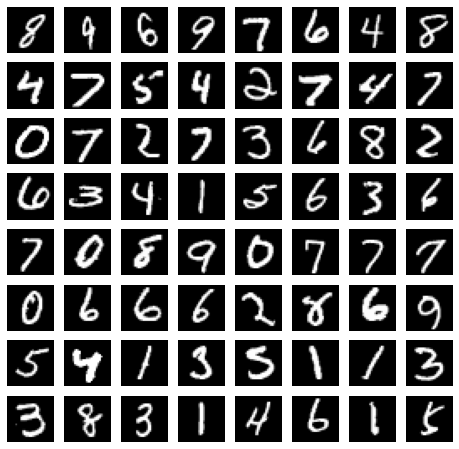

In [ ]:
fig, axes = pyplot.subplots(8,8,figsize=(8,8))
for i in range(8):
    for j in range(8):
        num_index = np.random.randint(len(X_train))
        axes[i,j].imshow(X_train[num_index].reshape((28,28)), cmap="gray")
        axes[i,j].axis("off")
pyplot.show() 

**Let's check how many of each tag are**

In [ ]:
# Let's check how many of each tag are.
y_train_total=0
y_valid_total=0
y_test_total=0
total=0
for i in range(10):
    print(i,">> train:", sum(y_train==i), ", valid:", sum(y_val==i), 
          ", test:", sum(y_test==i), ", total:", sum(y_train==i)+sum(y_val==i)+sum(y_test==i) )
    y_train_total=y_train_total + sum(y_train==i)
    y_valid_total=y_valid_total + sum(y_val==i)
    y_test_total=y_test_total + sum(y_test==i)
    total=total+sum(y_train==i)+sum(y_val==i)+sum(y_test==i)
    
print("y_train_total=", y_train_total) 
print("y_valid_total=", y_valid_total) 
print("y_test_total=", y_test_total)
print("total=", total)

0 >> train: 4971 , valid: 952 , test: 980 , total: 6903
1 >> train: 5592 , valid: 1150 , test: 1135 , total: 7877
2 >> train: 4980 , valid: 978 , test: 1032 , total: 6990
3 >> train: 5102 , valid: 1029 , test: 1010 , total: 7141
4 >> train: 4860 , valid: 982 , test: 982 , total: 6824
5 >> train: 4505 , valid: 916 , test: 892 , total: 6313
6 >> train: 4905 , valid: 1013 , test: 958 , total: 6876
7 >> train: 5211 , valid: 1054 , test: 1028 , total: 7293
8 >> train: 4891 , valid: 960 , test: 974 , total: 6825
9 >> train: 4983 , valid: 966 , test: 1009 , total: 6958
y_train_total= 50000
y_valid_total= 10000
y_test_total= 10000
total= 70000


In [ ]:
def split_and_shuffle_labels(y_data, seed, amount):
    y_data=pd.DataFrame(y_data,columns=["labels"])
    y_data["i"]=np.arange(len(y_data))
    label_dict = dict()
    for i in range(10):
        var_name="label" + str(i)
        label_info=y_data[y_data["labels"]==i]
        np.random.seed(seed)
        label_info=np.random.permutation(label_info)
        label_info=label_info[0:amount]
        label_info=pd.DataFrame(label_info, columns=["labels","i"])
        label_dict.update({var_name: label_info })
    return label_dict

In [ ]:
def get_iid_subsamples_indices(label_dict, number_of_samples, amount):
    sample_dict= dict()
    batch_size=int(math.floor(amount/number_of_samples))
    for i in range(number_of_samples):
        sample_name="sample"+str(i)
        dumb=pd.DataFrame()
        for j in range(10):
            label_name=str("label")+str(j)
            a=label_dict[label_name][i*batch_size:(i+1)*batch_size]
            dumb=pd.concat([dumb,a], axis=0)
        dumb.reset_index(drop=True, inplace=True)    
        sample_dict.update({sample_name: dumb}) 
    return sample_dict

In [ ]:
def create_iid_subsamples(sample_dict, x_data, y_data, x_name, y_name):
    x_data_dict= dict()
    y_data_dict= dict()
    
    for i in range(len(sample_dict)):  ### len(sample_dict)= number of samples
        xname= x_name+str(i)
        yname= y_name+str(i)
        sample_name="sample"+str(i)
        
        indices=np.sort(np.array(sample_dict[sample_name]["i"]))
        
        x_info= x_data[indices,:]
        x_data_dict.update({xname : x_info})
        
        y_info= y_data[indices]
        y_data_dict.update({yname : y_info})
        
    return x_data_dict, y_data_dict

--------------------------
### <span style="background-color:#F087F9"> Classification Model </span> 

In [ ]:
class Net2nn(nn.Module):
    def __init__(self):
        super(Net2nn, self).__init__()
        self.fc1=nn.Linear(784,200)
        self.fc2=nn.Linear(200,200)
        self.fc3=nn.Linear(200,10)
        
    def forward(self,x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

In [ ]:
# class Net2nn(nn.Module):   
#     def __init__(self):
#         super(Net2nn, self).__init__()

#         self.cnn_layers = Sequential(
#             # Defining a 2D convolution layer
#             nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(4),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             # Defining another 2D convolution layer
#             nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(4),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )

#         self.linear_layers = nn.Sequential(
#             nn.Linear(4 * 7 * 7, 10)
#         )

#     # Defining the forward pass    
#     def forward(self, x):
#         x = self.cnn_layers(x)
#         x = x.view(x.size(0), -1)
#         x = self.linear_layers(x)
#         return x


In [ ]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [ ]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0

    for data, target in train_loader:
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        prediction = output.argmax(dim=1, keepdim=True)
        correct += prediction.eq(target.view_as(prediction)).sum().item()
        

    return train_loss / len(train_loader), correct/len(train_loader.dataset)

In [ ]:
def validation(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            
            test_loss += criterion(output, target).item()
            prediction = output.argmax(dim=1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    test_loss /= len(test_loader)
    correct /= len(test_loader.dataset)

    return (test_loss, correct)

---------------------------------
### <span style="background-color:#F087F9"> Functions for Federated Averaging </span> 

In [ ]:
def create_model_optimizer_criterion_dict(number_of_samples,learning_rate,momentum):
    model_dict = dict()
    optimizer_dict= dict()
    criterion_dict = dict()
    
    for i in range(number_of_samples):
        model_name="model"+str(i)
        model_info=Net2nn()
        model_dict.update({model_name : model_info })
        
        optimizer_name="optimizer"+str(i)
        optimizer_info = torch.optim.SGD(model_info.parameters(), lr=learning_rate, momentum=momentum)
        optimizer_dict.update({optimizer_name : optimizer_info })
        
        criterion_name = "criterion"+str(i)
        criterion_info = nn.CrossEntropyLoss()
        criterion_dict.update({criterion_name : criterion_info})
        
    return model_dict, optimizer_dict, criterion_dict 

In [ ]:
def get_averaged_weights(model_dict, number_of_samples):
   
    fc1_mean_weight = torch.zeros(size=model_dict[name_of_models[0]].fc1.weight.shape)
    fc1_mean_bias = torch.zeros(size=model_dict[name_of_models[0]].fc1.bias.shape)
    
    fc2_mean_weight = torch.zeros(size=model_dict[name_of_models[0]].fc2.weight.shape)
    fc2_mean_bias = torch.zeros(size=model_dict[name_of_models[0]].fc2.bias.shape)
    
    fc3_mean_weight = torch.zeros(size=model_dict[name_of_models[0]].fc3.weight.shape)
    fc3_mean_bias = torch.zeros(size=model_dict[name_of_models[0]].fc3.bias.shape)
    
    with torch.no_grad():
    
    
        for i in range(number_of_samples):
            fc1_mean_weight += model_dict[name_of_models[i]].fc1.weight.data.clone()
            fc1_mean_bias += model_dict[name_of_models[i]].fc1.bias.data.clone()
        
            fc2_mean_weight += model_dict[name_of_models[i]].fc2.weight.data.clone()
            fc2_mean_bias += model_dict[name_of_models[i]].fc2.bias.data.clone()
        
            fc3_mean_weight += model_dict[name_of_models[i]].fc3.weight.data.clone()
            fc3_mean_bias += model_dict[name_of_models[i]].fc3.bias.data.clone()

        
        fc1_mean_weight =fc1_mean_weight/number_of_samples
        fc1_mean_bias = fc1_mean_bias/ number_of_samples
    
        fc2_mean_weight =fc2_mean_weight/number_of_samples
        fc2_mean_bias = fc2_mean_bias/ number_of_samples
    
        fc3_mean_weight =fc3_mean_weight/number_of_samples
        fc3_mean_bias = fc3_mean_bias/ number_of_samples
    
    return fc1_mean_weight, fc1_mean_bias, fc2_mean_weight, fc2_mean_bias, fc3_mean_weight, fc3_mean_bias

In [ ]:
def set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_samples):
    fc1_mean_weight, fc1_mean_bias, fc2_mean_weight, fc2_mean_bias, fc3_mean_weight, fc3_mean_bias = get_averaged_weights(model_dict, number_of_samples=number_of_samples)
    with torch.no_grad():
        main_model.fc1.weight.data = fc1_mean_weight.data.clone()
        main_model.fc2.weight.data = fc2_mean_weight.data.clone()
        main_model.fc3.weight.data = fc3_mean_weight.data.clone()

        main_model.fc1.bias.data = fc1_mean_bias.data.clone()
        main_model.fc2.bias.data = fc2_mean_bias.data.clone()
        main_model.fc3.bias.data = fc3_mean_bias.data.clone() 
    return main_model

In [ ]:
def compare_local_and_merged_model_performance(number_of_samples):
    accuracy_table=pd.DataFrame(data=np.zeros((number_of_samples,3)), columns=["sample", "local_ind_model", "merged_main_model"])
    for i in range (number_of_samples):
    
        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        individual_loss, individual_accuracy = validation(model, test_dl, criterion)
        main_loss, main_accuracy =validation(main_model, test_dl, main_criterion )
    
        accuracy_table.loc[i, "sample"]="sample "+str(i)
        accuracy_table.loc[i, "local_ind_model"] = individual_accuracy
        accuracy_table.loc[i, "merged_main_model"] = main_accuracy

    return accuracy_table

In [ ]:
def send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples):
    with torch.no_grad():
        for i in range(number_of_samples):

            model_dict[name_of_models[i]].fc1.weight.data =main_model.fc1.weight.data.clone()
            model_dict[name_of_models[i]].fc2.weight.data =main_model.fc2.weight.data.clone()
            model_dict[name_of_models[i]].fc3.weight.data =main_model.fc3.weight.data.clone() 
            
            model_dict[name_of_models[i]].fc1.bias.data =main_model.fc1.bias.data.clone()
            model_dict[name_of_models[i]].fc2.bias.data =main_model.fc2.bias.data.clone()
            model_dict[name_of_models[i]].fc3.bias.data =main_model.fc3.bias.data.clone() 
    
    return model_dict

In [ ]:
def start_train_end_node_process(number_of_samples):
    for i in range (number_of_samples): 

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

#         valid_ds = TensorDataset(x_valid_dict[name_of_x_valid_sets[i]], y_valid_dict[name_of_y_valid_sets[i]])
#         valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)
        
        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size= batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        print("Subset" ,i)
        for epoch in range(numEpoch):        
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
#             valid_loss, valid_accuracy = validation(model, valid_dl, criterion)
            test_loss, test_accuracy = validation(model, test_dl, criterion)
    
            print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.5f}".format(train_accuracy) + " | test accuracy: {:7.5f}".format(test_accuracy))

In [ ]:

def start_train_end_node_process_without_print(number_of_samples):
    for i in range (number_of_samples): 

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size= batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        for epoch in range(numEpoch):        
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
            test_loss, test_accuracy = validation(model, test_dl, criterion)

In [ ]:
y_train_dict[name_of_y_train_sets[10]].dtype

torch.int64

In [ ]:
i = 10
train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
test_dl = DataLoader(test_ds, batch_size= batch_size * 2)

model=model_dict[name_of_models[i]]
criterion=criterion_dict[name_of_criterions[i]]
optimizer=optimizer_dict[name_of_optimizers[i]]

if i<print_amount:
    print("Subset" ,i)
    
for epoch in range(numEpoch):

    train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
    test_loss, test_accuracy = validation(model, test_dl, criterion)
    
    if i<print_amount:        
        print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.5f}".format(train_accuracy) + " | test accuracy: {:7.5f}".format(test_accuracy))

In [ ]:
def start_train_end_node_process_print_some(number_of_samples, print_amount):
    for i in range (number_of_samples): 

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size= batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        if i<print_amount:
            print("Subset" ,i)
            
        for epoch in range(numEpoch):
        
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
            test_loss, test_accuracy = validation(model, test_dl, criterion)
            
            if i<print_amount:        
                print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.5f}".format(train_accuracy) + " | test accuracy: {:7.5f}".format(test_accuracy))    

In [ ]:
x_train, y_train, x_valid, y_valid,x_test, y_test = map(torch.tensor, (X_train, y_train, X_val, y_val, X_test, y_test))

y_train = y_train.type(torch.LongTensor)
y_valid = y_valid.type(torch.LongTensor)
y_test = y_test.type(torch.LongTensor)

number_of_samples=100
learning_rate = 0.01
numEpoch = 10
batch_size = 32
momentum = 0.9

train_amount=4500
valid_amount=900
test_amount=900
print_amount=3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [ ]:
50000/4500

11.11111111111111

----------------

### <span style="background-color:#F087F9"> Let's examine what would the performance of the centralized model be if the data were not distributed to nodes at all? </span>   

The model used in this example is very simple, different things can be done to improve model performance, such as using more complex models, increasing epoch or hyperparameter tuning. However, the purpose here is to compare the performance of the main model that is formed by combining the parameters of the local models trained on their own data with a centralized model that trained on all training data. In this way, we can gain insight into the capacity of federated learning.


In [ ]:
centralized_model = Net2nn()
centralized_optimizer = torch.optim.SGD(centralized_model.parameters(), lr=0.01, momentum=0.9)
centralized_criterion = nn.CrossEntropyLoss()

In [ ]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

In [ ]:
print("------ Centralized Model ------")
for epoch in range(numEpoch):
    central_train_loss, central_train_accuracy = train(centralized_model, train_dl, centralized_criterion, centralized_optimizer)
    central_test_loss, central_test_accuracy = validation(centralized_model, test_dl, centralized_criterion)
    
    print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.4f}".format(central_train_accuracy) + " | test accuracy: {:7.4f}".format(central_test_accuracy))

print("------ Training finished ------")

------ Centralized Model ------
epoch:   1 | train accuracy:  0.9986 | test accuracy:  0.9793
epoch:   2 | train accuracy:  0.9990 | test accuracy:  0.9795
epoch:   3 | train accuracy:  0.9997 | test accuracy:  0.9809
epoch:   4 | train accuracy:  0.9998 | test accuracy:  0.9808
epoch:   5 | train accuracy:  0.9999 | test accuracy:  0.9816
epoch:   6 | train accuracy:  1.0000 | test accuracy:  0.9814
epoch:   7 | train accuracy:  1.0000 | test accuracy:  0.9815
epoch:   8 | train accuracy:  1.0000 | test accuracy:  0.9815
epoch:   9 | train accuracy:  1.0000 | test accuracy:  0.9810
epoch:  10 | train accuracy:  1.0000 | test accuracy:  0.9812
------ Training finished ------



----------------
-----------------
**Data is distributed to nodes**

<!-- ### <span style="background-color:#F087F9"> Datanın nodelara dağıtılması </span>    -->

In [ ]:
valid_dl.

In [ ]:
centralized_model.eval()

with torch.no_grad():
  for data, target in valid_dl:
    output = centralized_model(data) 
    predictions = output.argmax(dim=1, keepdim=True)
    for a,b in zip(predictions,target):
      if a.item() != b.item():
        print(a.item(),b.item())
    break

2 3


In [ ]:
full_output[0]

tensor([[-7.2276e+00, -2.3302e+00,  5.7924e+00,  3.0447e+01, -1.9727e+01,
          5.5094e+00, -1.9829e+01,  1.1468e+00,  5.1777e+00,  2.4399e-01],
        [-5.8963e+00,  7.2713e+00,  3.0742e+01,  5.4823e+00, -1.5012e+01,
         -1.2790e+01, -6.9552e-01,  1.2813e+01, -2.9695e+00, -2.0825e+01],
        [ 2.6218e+00, -9.1090e+00,  1.8607e+00, -8.5736e+00,  2.4182e+00,
         -5.0218e+00, -1.1260e+01,  2.3907e+01, -8.3308e+00,  1.0828e+01],
        [-7.0610e+00, -4.1589e+00,  2.4149e+00,  5.9527e+00, -6.1239e+00,
         -1.8943e+00, -8.6573e+00, -5.4855e+00,  2.5114e+01,  1.0185e+00],
        [-1.1499e+01,  6.8759e+00,  2.6537e+01,  5.8371e+00, -8.0080e+00,
         -2.3157e+00, -3.6150e+00,  4.3953e+00, -4.6042e+00, -1.4256e+01],
        [-9.8228e+00, -2.3242e+00,  3.4766e+00,  3.1020e+01, -1.6621e+01,
          2.4626e+00, -1.9890e+01,  2.0016e+00,  6.4451e+00,  2.5534e+00],
        [-1.0435e+01,  8.4608e+00, -7.4585e+00, -5.8629e-01, -2.4167e+00,
          1.3079e+01,  2.7749e+0

In [ ]:
label_dict_train=split_and_shuffle_labels(y_data=y_train, seed=1, amount=train_amount) 


In [ ]:
label_dict_train['label0'].loc[1:10,:]

,labels,i
1,0,46399
2,0,46207
3,0,42130
4,0,44287
5,0,12156
6,0,42700
7,0,35076
8,0,44988
9,0,34844
10,0,7519


In [ ]:
sample_dict_train=get_iid_subsamples_indices(label_dict=label_dict_train, number_of_samples=number_of_samples, amount=train_amount)

In [ ]:
d = sample_dict_train['sample0']

In [ ]:

d[d['labels'] == 0].shape

(45, 2)

In [ ]:
x_train_dict, y_train_dict = create_iid_subsamples(sample_dict=sample_dict_train, x_data=x_train, y_data=y_train, x_name="x_train", y_name="y_train")


In [ ]:
x_train_dict.keys()

dict_keys(['x_train0', 'x_train1', 'x_train2', 'x_train3', 'x_train4', 'x_train5', 'x_train6', 'x_train7', 'x_train8', 'x_train9', 'x_train10', 'x_train11', 'x_train12', 'x_train13', 'x_train14', 'x_train15', 'x_train16', 'x_train17', 'x_train18', 'x_train19', 'x_train20', 'x_train21', 'x_train22', 'x_train23', 'x_train24', 'x_train25', 'x_train26', 'x_train27', 'x_train28', 'x_train29', 'x_train30', 'x_train31', 'x_train32', 'x_train33', 'x_train34', 'x_train35', 'x_train36', 'x_train37', 'x_train38', 'x_train39', 'x_train40', 'x_train41', 'x_train42', 'x_train43', 'x_train44', 'x_train45', 'x_train46', 'x_train47', 'x_train48', 'x_train49', 'x_train50', 'x_train51', 'x_train52', 'x_train53', 'x_train54', 'x_train55', 'x_train56', 'x_train57', 'x_train58', 'x_train59', 'x_train60', 'x_train61', 'x_train62', 'x_train63', 'x_train64', 'x_train65', 'x_train66', 'x_train67', 'x_train68', 'x_train69', 'x_train70', 'x_train71', 'x_train72', 'x_train73', 'x_train74', 'x_train75', 'x_train76'

In [ ]:
label_dict_train=split_and_shuffle_labels(y_data=y_train, seed=1, amount=train_amount) 
sample_dict_train=get_iid_subsamples_indices(label_dict=label_dict_train, number_of_samples=number_of_samples, amount=train_amount)
x_train_dict, y_train_dict = create_iid_subsamples(sample_dict=sample_dict_train, x_data=x_train, y_data=y_train, x_name="x_train", y_name="y_train")


label_dict_valid = split_and_shuffle_labels(y_data=y_valid, seed=1, amount=valid_amount) 
sample_dict_valid = get_iid_subsamples_indices(label_dict=label_dict_valid, number_of_samples=number_of_samples, amount=valid_amount)
x_valid_dict, y_valid_dict = create_iid_subsamples(sample_dict=sample_dict_valid, x_data=x_valid, y_data=y_valid, x_name="x_valid", y_name="y_valid")

label_dict_test = split_and_shuffle_labels(y_data=y_test, seed=1, amount=test_amount) 
sample_dict_test = get_iid_subsamples_indices(label_dict=label_dict_test, number_of_samples=number_of_samples, amount=test_amount)
x_test_dict, y_test_dict = create_iid_subsamples(sample_dict=sample_dict_test, x_data=x_test, y_data=y_test, x_name="x_test", y_name="y_test")

torch.Size([450, 784]) torch.Size([450])
torch.Size([90, 784]) torch.Size([90])
torch.Size([90, 784]) torch.Size([90])
tensor(7)


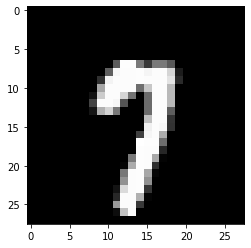

In [ ]:
print(x_train_dict["x_train1"].shape, y_train_dict["y_train1"].shape)
print(x_valid_dict["x_valid1"].shape, y_valid_dict["y_valid1"].shape) 
print(x_test_dict["x_test1"].shape, y_test_dict["y_test1"].shape)

num_index = np.random.randint(test_amount/number_of_samples*10)
pyplot.imshow(x_test_dict["x_test1"][num_index].reshape((28,28)), cmap="gray")
print(y_test_dict["y_test1"][num_index])

**Main model is created**

In [ ]:
main_model = Net2nn()
main_optimizer = torch.optim.SGD(main_model.parameters(), lr=learning_rate, momentum=0.9)
main_criterion = nn.CrossEntropyLoss()

NameError: ignored

**Models,optimizers and loss functions in nodes are defined**

In [ ]:
model_dict, optimizer_dict, criterion_dict = create_model_optimizer_criterion_dict(number_of_samples,learning_rate,momentum)

**Keys of dicts are being made iterable**

In [ ]:
type(x_train_dict.keys())

dict_keys

In [ ]:
name_of_x_train_sets=list(x_train_dict.keys())
name_of_y_train_sets=list(y_train_dict.keys())
name_of_x_valid_sets=list(x_valid_dict.keys())
name_of_y_valid_sets=list(y_valid_dict.keys())
name_of_x_test_sets=list(x_test_dict.keys())
name_of_y_test_sets=list(y_test_dict.keys())

name_of_models=list(model_dict.keys())
name_of_optimizers=list(optimizer_dict.keys())
name_of_criterions=list(criterion_dict.keys())

# print(name_of_x_train_sets)
# print(name_of_y_train_sets)
# print(name_of_x_valid_sets)
# print(name_of_y_valid_sets)
# print(name_of_x_test_sets)
# print(name_of_y_test_sets)
# print("\n ------------")
# print(name_of_models)
# print(name_of_optimizers)
# print(name_of_criterions)

In [ ]:
len(main_model.fc2.weight)

200

In [ ]:
print(main_model.fc2.weight[0:1,0:5])
print(model_dict["model1"].fc2.weight[0:1,0:5])

tensor([[ 0.0587, -0.0059,  0.0627,  0.0130, -0.0042]],
       grad_fn=<SliceBackward>)
tensor([[ 0.0005,  0.0615,  0.0201,  0.0401, -0.0654]],
       grad_fn=<SliceBackward>)


**Parameters of main model are sent to nodes**  
Since the parameters of the main model and parameters of all local models in the nodes are randomly initialized, all these parameters will be different from each other. For this reason, the main model sends its parameters to the nodes before the training of local models in the nodes begins. You can check the weights below.

In [ ]:
model_dict=send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples)

In [ ]:
print(main_model.fc2.weight[0:1,0:5])
print(model_dict["model99"].fc2.weight[0:1,0:5])

tensor([[ 0.0587, -0.0059,  0.0627,  0.0130, -0.0042]],
       grad_fn=<SliceBackward>)
tensor([[ 0.0587, -0.0059,  0.0627,  0.0130, -0.0042]],
       grad_fn=<SliceBackward>)


**Models in the nodes are trained**

In [ ]:
# start_train_end_node_process()
start_train_end_node_process_print_some(number_of_samples, print_amount)

Subset 0
epoch:   1 | train accuracy: 0.18889 | test accuracy: 0.30000
epoch:   2 | train accuracy: 0.41111 | test accuracy: 0.42222
epoch:   3 | train accuracy: 0.52667 | test accuracy: 0.53333
epoch:   4 | train accuracy: 0.57111 | test accuracy: 0.61111
epoch:   5 | train accuracy: 0.68667 | test accuracy: 0.64444
epoch:   6 | train accuracy: 0.72667 | test accuracy: 0.76667
epoch:   7 | train accuracy: 0.80222 | test accuracy: 0.65556
epoch:   8 | train accuracy: 0.73111 | test accuracy: 0.75556
epoch:   9 | train accuracy: 0.79556 | test accuracy: 0.73333
epoch:  10 | train accuracy: 0.85333 | test accuracy: 0.73333
Subset 1
epoch:   1 | train accuracy: 0.11333 | test accuracy: 0.16667
epoch:   2 | train accuracy: 0.28667 | test accuracy: 0.41111
epoch:   3 | train accuracy: 0.45556 | test accuracy: 0.37778
epoch:   4 | train accuracy: 0.47556 | test accuracy: 0.52222
epoch:   5 | train accuracy: 0.60667 | test accuracy: 0.58889
epoch:   6 | train accuracy: 0.66889 | test accuracy

In [ ]:
## As you can see, wieghts of local models are updated after training process
print(main_model.fc2.weight[0,0:5])
print(model_dict["model1"].fc2.weight[0,0:5])

tensor([-0.0262,  0.0325,  0.0636, -0.0280, -0.0387], grad_fn=<SliceBackward>)
tensor([ 0.0577, -0.0099,  0.0662,  0.0272, -0.0166], grad_fn=<SliceBackward>)


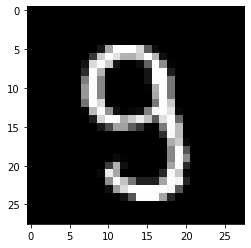

In [ ]:
pyplot.imshow(x_test_dict["x_test1"][10].reshape((28,28)), cmap="gray")

In [ ]:
model_tmp = model_dict["model1"]


In [ ]:
print(model_tmp)

Net2nn(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)


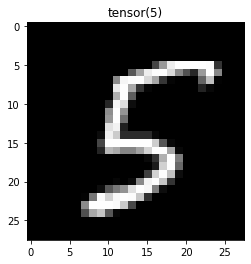

tensor([ 0.8263, -1.9254, -0.7504,  0.3236, -1.4792,  3.2591,  0.5135, -3.1834,
         2.0839,  0.0483])


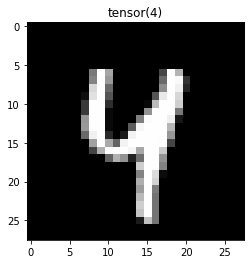

tensor([-5.2060, -1.9026, -1.8418, -2.3945,  6.3896, -1.0521, -1.7287,  0.3188,
         1.4237,  5.3118])


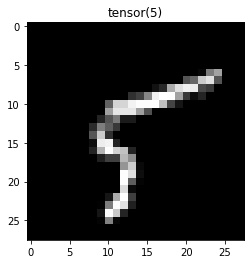

tensor([ 0.4412, -1.6585, -1.3993, -0.1947, -0.2258,  1.2013, -1.3383,  1.3030,
         0.2539,  0.9611])


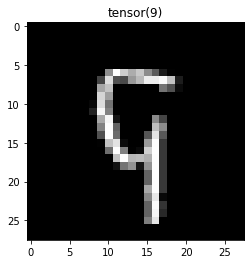

tensor([-0.7764, -2.3865, -0.1124, -2.5427,  2.3423,  0.3183,  0.5200, -0.6677,
         0.6279,  2.6043])


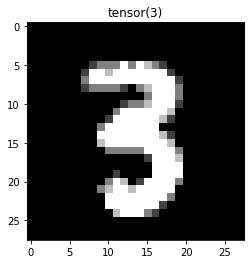

tensor([-2.2277,  0.0754, -1.8814,  6.0498, -3.7235,  4.5896, -5.1379, -4.4976,
         5.1256,  0.3571])


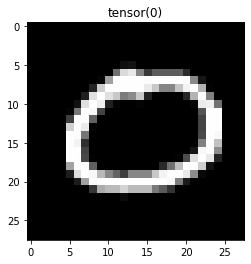

tensor([ 6.6266, -5.5447,  2.5062, -1.6825, -4.0327,  3.5545,  1.8898, -2.1243,
         0.8316, -1.6030])


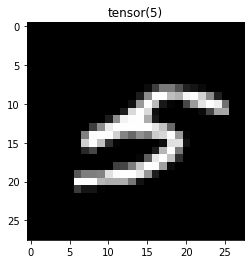

tensor([-1.7183, -0.4172, -1.0591,  0.1709,  0.9139,  1.2320, -0.3228, -1.1294,
         0.7506,  1.1706])


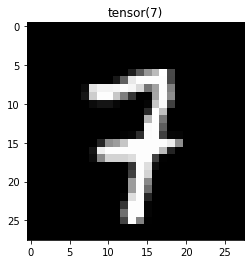

tensor([-3.5033, -0.2179, -0.6246, -1.8944,  2.4909, -0.8139, -1.4029,  0.2374,
         1.7885,  3.5640])


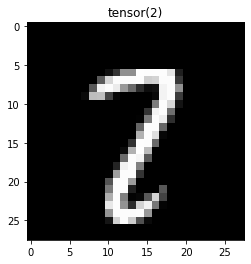

tensor([-1.8540,  0.4616,  0.0244,  0.9739, -1.5512,  0.3386, -3.5972,  0.5327,
         2.7544,  1.2767])


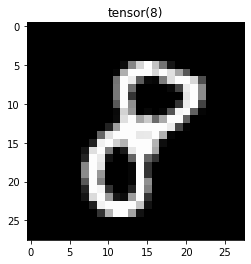

tensor([-2.4303,  0.6232, -0.6641,  1.2463, -0.6951,  1.5052, -1.9112, -3.7553,
         4.9475,  0.7695])


In [ ]:
with torch.no_grad():
  model_tmp.eval()
  for i in range(10):
    pyplot.imshow(x_test_dict["x_test1"][i].reshape((28,28)), cmap="gray")
    pyplot.title(y_test_dict["y_test1"][i])
    pyplot.show()
    print(model_tmp(x_test_dict["x_test1"][i]))

tensor([-0.3299, -2.6791, -1.5458,  2.7544, -0.8737,  2.8483, -3.6477, -0.7090,
         1.7791,  1.3609], grad_fn=<AddBackward0>)

In [ ]:
torch.softmax(main_model.forward(x_test_dict["x_test1"][10]),0)


tensor([0.1055, 0.0965, 0.0981, 0.0931, 0.1071, 0.0920, 0.1043, 0.1004, 0.1007,
        0.1023], grad_fn=<SoftmaxBackward>)

### Let's compare the performance of federated main model, individual local models and centralized model  

**Federated main model vs individual local models before 1st iteration (on distributed test set)**  
Since main model is randomly initialized and no action taken on it yet, its performance is very poor. Please before_acc_table

In [ ]:
before_acc_table=compare_local_and_merged_model_performance(number_of_samples=number_of_samples)
before_test_loss, before_test_accuracy = validation(main_model, test_dl, main_criterion)

main_model= set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_samples) 

after_acc_table=compare_local_and_merged_model_performance(number_of_samples=number_of_samples)
after_test_loss, after_test_accuracy = validation(main_model, test_dl, main_criterion)

In [ ]:
print("Federated main model vs individual local models before FedAvg first iteration")
before_acc_table.head()

Federated main model vs individual local models before FedAvg first iteration


,sample,local_ind_model,merged_main_model
0,sample 0,0.8111,0.0889
1,sample 1,0.7667,0.1222
2,sample 2,0.7111,0.1556
3,sample 3,0.8111,0.1222
4,sample 4,0.7222,0.1222


In [ ]:
print("Federated main model vs individual local models after FedAvg first iteration")
after_acc_table.head()

Federated main model vs individual local models after FedAvg first iteration


,sample,local_ind_model,merged_main_model
0,sample 0,0.8111,0.9000
1,sample 1,0.7667,0.8222
2,sample 2,0.7111,0.7889
3,sample 3,0.8111,0.8556
4,sample 4,0.7222,0.8667


**Federated main model vs centralized model before 1st iteration (on all test data)**  
Please be aware that the centralized model gets approximately %98 accuracy on all test data.

In [ ]:
print("Before 1st iteration main model accuracy on all test data: {:7.4f}".format(before_test_accuracy))
print("After 1st iteration main model accuracy on all test data: {:7.4f}".format(after_test_accuracy))
print("Centralized model accuracy on all test data: {:7.4f}".format(central_test_accuracy))

Before 1st iteration main model accuracy on all test data:  0.1152
After 1st iteration main model accuracy on all test data:  0.8556
Centralized model accuracy on all test data:  0.9779


This is a single iteration, we can send the weights of the main model back to the nodes and repeat the above steps.
Now let's check how the performance of the main model improves when we repeat the iteration 10 more times.

In [ ]:
for i in range(10):
    model_dict=send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples)
    start_train_end_node_process_without_print(number_of_samples)
    main_model= set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_samples) 
    test_loss, test_accuracy = validation(main_model, test_dl, main_criterion)
    print("Iteration", str(i+2), ": main_model accuracy on all test data: {:7.4f}".format(test_accuracy))   

Iteration 2 : main_model accuracy on all test data:  0.8973
Iteration 3 : main_model accuracy on all test data:  0.9098
Iteration 4 : main_model accuracy on all test data:  0.9173
Iteration 5 : main_model accuracy on all test data:  0.9231
Iteration 6 : main_model accuracy on all test data:  0.9295
Iteration 7 : main_model accuracy on all test data:  0.9348
Iteration 8 : main_model accuracy on all test data:  0.9370
Iteration 9 : main_model accuracy on all test data:  0.9393
Iteration 10 : main_model accuracy on all test data:  0.9427
Iteration 11 : main_model accuracy on all test data:  0.9441


The accuracy of the centralized model was calculated as approximately 98%. The accuracy of the main model obtained by FedAvg method started from 85% and improved to 94%. In this case, we can say that although the main model obtained by FedAvg method was trained without seeing the data, its performance cannot be underestimated.

In [ ]:
from sklearn.utils import shuffle
import numpy as np

X = np.array([[0, 0, 0, 0], [1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3], [4, 4, 4, 4],
              [5, 5, 5, 5], [6, 6, 6, 6], [7, 7, 7, 7], [8, 8, 8, 8], [9, 9, 9, 9],
              [10, 10, 10, 10], [11, 11, 11, 11], [12, 12, 12, 12], [13, 13, 13, 13], [14, 14, 14, 14],
              [15, 15, 15, 15], [16, 16, 16, 16], [17, 17, 17, 17], [18, 18, 18, 18], [19, 19, 19, 19]])
y = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

print(X)
print(y)

[[ 0  0  0  0]
 [ 1  1  1  1]
 [ 2  2  2  2]
 [ 3  3  3  3]
 [ 4  4  4  4]
 [ 5  5  5  5]
 [ 6  6  6  6]
 [ 7  7  7  7]
 [ 8  8  8  8]
 [ 9  9  9  9]
 [10 10 10 10]
 [11 11 11 11]
 [12 12 12 12]
 [13 13 13 13]
 [14 14 14 14]
 [15 15 15 15]
 [16 16 16 16]
 [17 17 17 17]
 [18 18 18 18]
 [19 19 19 19]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [ ]:
print(X.shape)

(20, 4)


In [ ]:
print(y.shape)

(20,)


In [ ]:
X, y = shuffle(X, y, random_state=42)

In [ ]:
print(X)

[[ 0  0  0  0]
 [17 17 17 17]
 [15 15 15 15]
 [ 1  1  1  1]
 [ 8  8  8  8]
 [ 5  5  5  5]
 [11 11 11 11]
 [ 3  3  3  3]
 [18 18 18 18]
 [16 16 16 16]
 [13 13 13 13]
 [ 2  2  2  2]
 [ 9  9  9  9]
 [19 19 19 19]
 [ 4  4  4  4]
 [12 12 12 12]
 [ 7  7  7  7]
 [10 10 10 10]
 [14 14 14 14]
 [ 6  6  6  6]]


In [ ]:
print(y)

[ 0 17 15  1  8  5 11  3 18 16 13  2  9 19  4 12  7 10 14  6]


In [ ]:
X_trains = np.array_split(X, 5)

In [ ]:
y_trains = np.array_split(y, 5)

In [ ]:
print(X_trains[0])

[[ 0  0  0  0]
 [17 17 17 17]
 [15 15 15 15]
 [ 1  1  1  1]]


In [ ]:
print(y_trains[0])

[ 0 17 15  1]
